### Usando o modelo CLIP para identificar conceitos em uma imagem

Podemos calcular a similaridade entre textos codificados e patches de uma imagem para localizar objetos em uma imagem.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, image_transforms

class CLIPSaliency:
    """Geração de mapas de saliência em imagens a partir de textos."""

    def __init__(self, device='cpu'):

        model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

        self.model = model
        self.processor = processor
        self.device = device

    def get_token_similarity(self, texts, image):
        """Obtenção de similaridade entre um batch de textos e patches de uma
        imagem."""

        processor = self.processor
        inputs = processor.tokenizer(texts, return_tensors="pt", padding=True)
        image_features = processor.image_processor(image, return_tensors="pt")
        inputs["pixel_values"] = image_features.pixel_values
        
        with torch.no_grad():
            outputs = self.model(**inputs.to(self.device))

        # Tokens dos patches da imagem, tamanho 256 x 768
        image_embeds = outputs.vision_model_output.last_hidden_state[0,1:]
        # Token de texto
        text_embeds = outputs.text_embeds

        with torch.no_grad():
            # Projeção dos tokens
            image_embeds = self.model.visual_projection(image_embeds)
            # Similaridade entre cada token de imagem e o token de texto
            image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
            logits_per_image = torch.matmul(image_embeds, text_embeds.t())*self.model.logit_scale.exp()
            # Reshape para tamanho 16x16, assumindo que a imagem de entrada é
            # pré-processada para o tamanho 224x224 e o tamanho do patch do modelo
            # é 14x14
            logits_per_image = logits_per_image.t().reshape(text_embeds.shape[0], 16, 16)

        return logits_per_image

    def get_saliency(self, texts, image):
        """Criação das imagens de saliência."""

        logits_per_image = self.get_token_similarity(texts, image)

        # Redimensiona a saliência para o menor tamanho da imagem de entrada
        min_size = min(img.size)
        saliency_map = torch.nn.functional.interpolate(logits_per_image.unsqueeze(1), 
                                                       size=(min_size, min_size), 
                                                       mode='bicubic')[:,0]

        # Inverte o mapa de saliência, não consegui identificar porque o mapa
        # está invertido!
        saliency_map *= -1
        # Remove valores negativos
        saliency_map[saliency_map<0] = 0

        # Aplica um crop na imagem, pois ele é aplicado também no pré-processamento
        img_np = np.array(img)
        img_cropped = image_transforms.center_crop(img_np, (min_size, min_size))

        return img_cropped, saliency_map.cpu()

texts = ['disk', 'circle', 'round', 'cylinder']
img = Image.open('../data/man_with_dog.jpg')

CLIPS = CLIPSaliency()
img_cropped, saliency_map = CLIPS.get_saliency(texts=texts, image=img)

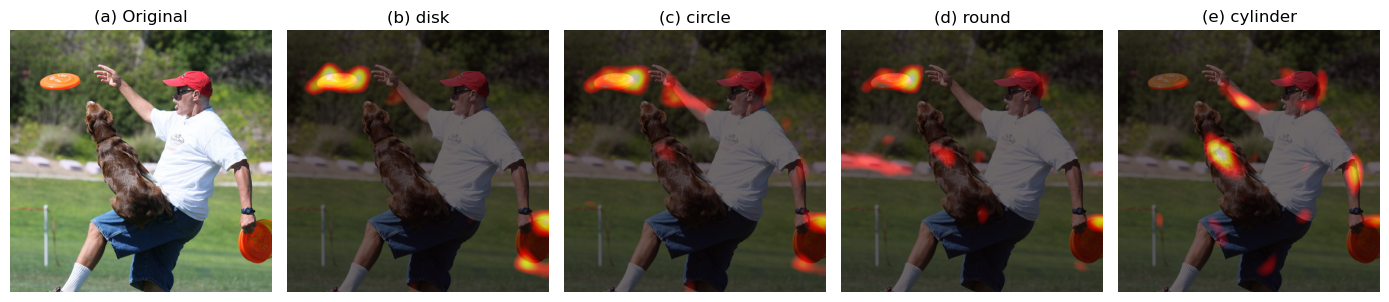

In [22]:
letters = ["(b)", "(c)", "(d)", "(e)"]
fig, axs = plt.subplots(1, 5, figsize=(14,3))
axs = axs.reshape(-1)
axs[0].imshow(img_cropped)
axs[0].axis('off')
axs[0].set_title("(a) Original")
for idx in range(len(texts)):
    ax = axs[idx+1]
    ax.imshow(img_cropped)
    ax.imshow(saliency_map[idx], 'hot', alpha=0.6)
    ax.set_title(f"{letters[idx]} {texts[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("siglip.pdf", bbox_inches = "tight")